In [1]:
# Import all required packages and libraries

import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.core.authentication import MsiAuthentication

from sklearn.model_selection import train_test_split
from fairlearn.widget import FairlearnDashboard
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.17.0 of the Azure ML SDK


In [3]:
# Authenticate into Azure ML Workspace with Managed Service Identity
print('creating MsiAuthentication...')
msi_auth = MsiAuthentication()
print('done creating MsiAuthentication!')

creating MsiAuthentication...
done creating MsiAuthentication!


In [4]:
# Get Workspace from the config file downloaded as config.json from the Azure Portal

ws = Workspace.from_config(auth=msi_auth)

# choose a name for experiment
experiment_name = 'automl-employee-turnover-fairlearn'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,93231767-b41d-4cbb-a2d3-2137400dfde2
Workspace,quick-start-ws
Resource Group,MCW-MLOps
Location,eastus
Experiment Name,automl-employee-turnover-fairlearn


In [5]:
# A compute target is required to train models
from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4,
                                                           min_nodes=0)
                    
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

In [6]:
# Training data was uploaded to Azure ML Workspace default datastore and already registered as a dataset

# Get the default datastore
datastore = ws.get_default_datastore()

# Since dtaa is in csv format, get dataset as tabular from the datastore
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'train-dataset/tabular/11-06-2020_102904_UTC/employee-turnover.csv')])

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()                       

,City,Email Domain,EmployeeLeft,Hired through SMTP,Manager Rating of Likelihood to leave,Marked for PHT Program,Most Recent Performance Evaluation,"Social Media Activity (Twitter, Facebook, Instagram)","Survey, Relative, Attitude toward WorkType","Survey, Relative, Attitude toward Workload","Survey, Relative, Peer's Average Attitude toward Manager"
0,Sandaohezi,exblog.jp,0.0,0,1.0,1,59.0,0,2,2,1
1,Bandung,youtu.be,1.0,0,21.0,0,49.0,2,1,2,3
2,Kuala Terengganu,cbslocal.com,0.0,1,1.0,1,51.0,1,3,1,2


In [15]:
X_raw = dataset.to_pandas_dataframe()

# Identify column to be predicted as label
label_column_name = 'EmployeeLeft'

Y_raw = dataset.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

print(X_raw["City"].value_counts().to_dict())

{'Nuoxizhi': 2995, 'Beaverlodge': 2933, 'Bandung': 2352, 'Liancheng': 2245, 'Ell': 2169, 'Kuala Terengganu': 1056, 'Sandaohezi': 250}


In [20]:
# Extract sensitive features from the data

dataset_fairness = dataset.drop_columns(columns=['City'])


In [22]:
# Split dataset into training and validation datasets
training_data, validation_data = dataset_fairness.random_split(percentage=0.8, seed=223)

In [31]:
# Split sensitive data into trainig and validation

sensitive_raw = dataset.keep_columns(columns=['City'], validate=True)

sensitive_train, sensitive_validate = sensitive_raw.random_split(percentage=0.8, seed=223)

In [24]:
# Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'accuracy',
    "featurization": 'auto',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 4, 
    "experiment_timeout_hours": 1,
    "verbosity": logging.INFO,
    "model_explainability": True
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

In [25]:
# Submit experiment
remote_run = experiment.submit(automl_config, show_output = False)

Running on remote.


In [26]:
# Wait for experiment to complete. This usually takes 20-30 mins
remote_run.wait_for_completion(show_output=True)


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.m

{'runId': 'AutoML_1a07ec31-1fc6-42d4-b5c9-acf1e9f24c67',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-10T05:08:58.269394Z',
 'endTimeUtc': '2020-11-10T05:35:22.197509Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-employee-turnover-fairlearn","subscription_id":"93231767-b41d-4cbb-a2d3-2137400dfde2","resource_group":"MCW-MLOps","workspace_name":"quick-start-ws","region":"eastus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_min":null,"y_max":null,

In [27]:
# Instantiate AutoMLRun object in order to get AutoML related metrics and output
from azureml.train.automl.run import AutoMLRun

automl_run = AutoMLRun(experiment = experiment, run_id = remote_run.run_id)

In [28]:
# Retrieve the best model and associated run id ad best_run
best_run, fitted_model = automl_run.get_output()

## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [32]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

# sensitive_train, 
sensitive_test_df = sensitive_validate.to_pandas_dataframe()

In [33]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [39]:
# Register the model identified by the best AutoML run
from azureml.core.model import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = best_run.register_model(model_name='employee-turnover-fairlearn',
                                model_path='outputs/model.pkl',
                                model_framework=Model.Framework.SCIKITLEARN,
                                model_framework_version='0.22.1',
                                resource_configuration=ResourceConfiguration(cpu=2, memory_in_gb=0.5),
                                description='employee-turnover-fairlearn best model created with AutoML',
                                tags={'area': 'employee turnover', 'type': 'classification'})


print(model.name, model.id, model.version, sep='\t')

employee-turnover-fairlearn	employee-turnover-fairlearn:1	1


In [40]:
ys_pred = {model.id:y_pred}

In [41]:
# Create local fairness dashboard

from fairlearn.widget import FairlearnDashboard

FairlearnDashboard(sensitive_features=sensitive_test_df,
                   sensitive_feature_names=['City'],
                   y_true=y_test_df,
                   y_pred=ys_pred)

FairlearnWidget(value={'true_y': [[1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0],…

In [42]:
# Compute Fairness Metrics
sf = {'City': sensitive_test_df.City}

from fairlearn.metrics._group_metric_set import _create_group_metric_set

dash_dict = _create_group_metric_set(y_true=y_test_df,
                                     predictions=ys_pred,
                                     sensitive_features=sf,
                                     prediction_type='binary_classification')

In [45]:
# Upload Fairness dashboard to Azure ML
from azureml.contrib.fairness import upload_dashboard_dictionary, download_dashboard_by_upload_id

print(experiment)

run = experiment.start_logging()

try:
    dashboard_title = "Employee Turnover Fairness"
    upload_id = upload_dashboard_dictionary(run,
                                            dash_dict,
                                            dashboard_name=dashboard_title)
    print("\nUploaded to id: {0}\n".format(upload_id))

    downloaded_dict = download_dashboard_by_upload_id(run, upload_id)

finally:
    run.complete()

Experiment(Name: automl-employee-turnover-fairlearn,
Workspace: quick-start-ws)

Uploaded to id: ad2dd6f7-a8e5-4d64-90ef-d70ec92d64c8



In [46]:
print(dash_dict == downloaded_dict)

True


### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

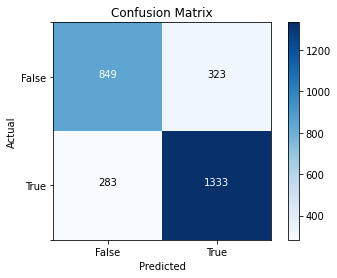

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()